In [1]:
"""
Generalized Predictive Coding on Moving MNIST
"""

import matplotlib.pyplot as plt
import torch
import math
import numpy as np
import IPython
import MovingMNIST as MovingMNIST
from model_circles import *
from circles_dataset import *
import torchvision.transforms as transforms


In [2]:
# Load dataset and create model

# settings
IMG_SIZE = 4; BATCH_SIZE = 1; gen_coords = 2

# dataset
if False:
    train_set = MovingMNIST(root='.data/mnist', train=True, download=True,
                        transform=transforms.Compose([transforms.Scale(IMG_SIZE), transforms.ToTensor(), ]))
else:
    frames = torch.from_numpy(np.load("./sample/train.npy")) # (400, 50, 1024)
    train_set = torch.utils.data.TensorDataset(frames,frames)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)

if True:
    frames = torch.zeros([1, 200, IMG_SIZE**2])
    for i, _ in enumerate(frames[0]):
        frames[:,i,i%IMG_SIZE**2] = 1
    train_set = torch.utils.data.TensorDataset(frames,frames)
    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)

net = GPC_net(b_size=BATCH_SIZE, dynamical_net=False, cause_sizes=[IMG_SIZE**2, 0],
              hidden_sizes=[0, 64], gen_coords=gen_coords, dt=1., length=199)


/Users/andre/PycharmProjects/BrainAI/venv/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [3]:
# Training function
def run_model(epochs = 1, inference_steps=1, sequences=200, generate=False, dt=.1, BURN_IN=6):
    # logging
    if generate: results = []
    errors, cov_h, errors_d1, errors_d2, errors_d3, cov_d1, cov_d2, cov_d3 = [[] for _ in range(8)]
    err_g1, err_g2, err_g3, cov_g1, cov_g2, cov_g3 = [[] for _ in range(6)]
    err_h1, err_h2, err_h3, l0, l1, l2, l3, l4, l5, l6 = [[] for _ in range(10)]

    for epoch in range(epochs):
        print("Epoch:", epoch)
        train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)

        for seq_id, (seq, _) in enumerate(train_loader):

            # set length of discrete sequence
            # seq = seq[:,:gen_coords]
            # seq = seq[:,:100] #

            # re-initialize hidden states
            if not generate:
                for layer in net.layers:
                    for d_layer in layer.dyn_model.layers:
                        torch.nn.init.xavier_normal_(d_layer.states.hidd_state)

            for repeat in range(5 if generate else 1): # train: single step, test: multistep
                if generate:
                    # state transition
                    net.layers[-1].dyn_model.forward_dynamical(apply=True, apply_encoding=True, dt=dt)
                else:
                    # update states and weights
                    for _ in range(inference_steps):

                        # feed cause
                        #net.generalized_feed(torch.transpose(seq, 0,1), time_to_batch=True, target=True)

                        # feed sensory data
                        net.generalized_feed(torch.transpose(seq, 0,1), time_to_batch=True) # todo improve

                        # step hierarchical
                        e, _, _, ch, _ = net.inference()

                        # step dynamical
                        eg1, eh1, ed1, cg1, cd1 = net.layers[-1].dyn_model.inference(predict_hierarchical=False)

                        # logging
                        errors, cov_h = errors + e, cov_h + ch
                        errors_d1, cov_d1 = errors_d1 + ed1, cov_d1 + cd1
                        err_g1, cov_g1, err_h1 = err_g1 + eg1, cov_g1 + cg1, err_h1+eh1

                # hierarchical posterior prediction
                pred = net.predict_from(start_layer=-1, overwrite=generate)

                 # collect prediction
                if generate:
                    results.append([p.copy() for p in pred])

            if seq_id == sequences:
                break

    # plot losses
    if not generate:
        plot_graph(errors, errors_d1, errors_d2, errors_d3, cov_d1, cov_d2, cov_d3,cov_g1,
           cov_g2, cov_g3, err_g1, err_g2, err_g3, err_h1, err_h2, err_h3, cov_h, hierarchical=True, g_coords=False, dynamical=True)

    if not generate:
        return pred, seq
    else:
        return results

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99


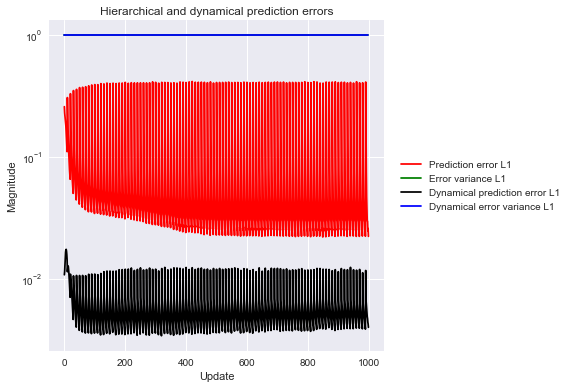

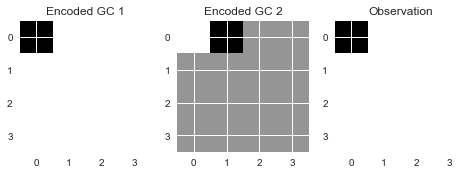

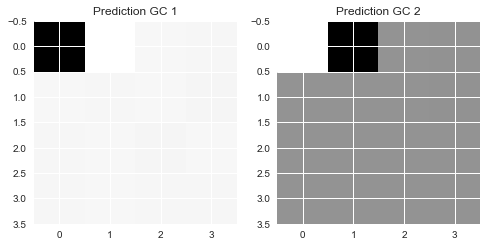

In [4]:
# Train model
pred, seq = run_model(epochs=100, sequences=0, inference_steps=10, dt=1)

# plot encoded sensory states
plot_sensory_coords(net, seq[0], IMG_SIZE=IMG_SIZE)

# plot predicted sensory states
plot_2D_coords(pred, IMG_SIZE=IMG_SIZE)

Epoch: 0


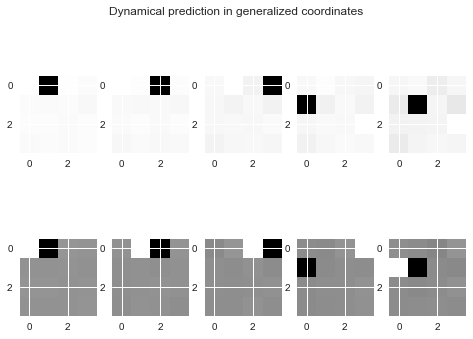

In [5]:
# Extrapolate model
results = run_model(epochs=1, sequences=0, inference_steps=0, generate=True, dt=1)
plot_2D_extrapolation(np.asarray(results).transpose([1,0,2,3]), IMG_SIZE=IMG_SIZE)

Epoch: 0


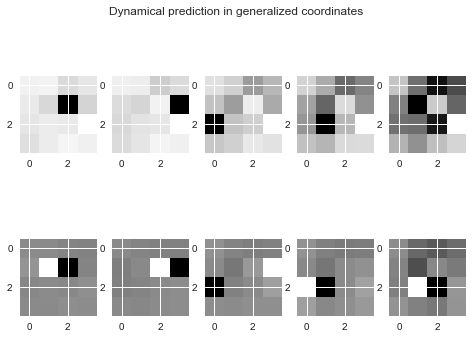

In [6]:
# Extrapolate model
results = run_model(epochs=1, sequences=0, inference_steps=0, generate=True, dt=1)
plot_2D_extrapolation(np.asarray(results).transpose([1,0,2,3]), IMG_SIZE=IMG_SIZE)